In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import preprocessing
from pylab import savefig
%matplotlib inline

In [2]:
path = '../data/winemag-clean.csv'
wine_clean = pd.read_csv(path, index_col = 0)
wine_clean.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,vintage,vintage_str_data,scaled_points
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,not_specified,not_specified,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011,2011 Avidagos Red (Douro),44.317767
2,US,"Tart and snappy, the flavors of lime flesh and...",no_designation,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013,2013 Pinot Gris (Willamette Valley),41.982247
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,not_specified,Alexander Peartree,no_twitter,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,2013 Reserve Late Harvest Riesling (Lake Mich...,57.575804
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,2012 Vintner's Reserve Wild Child Block Pinot...,41.982247
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,not_specified,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011,2011 Ars In Vitro Tempranillo-Merlot (Navarra),50.921302


In [3]:
wine_clean.drop(['vintage_str_data','scaled_points'], axis=1, inplace=True)

In [4]:
wine_clean.columns

Index(['country', 'description', 'designation', 'points', 'price', 'province',
       'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title',
       'variety', 'winery', 'vintage'],
      dtype='object')

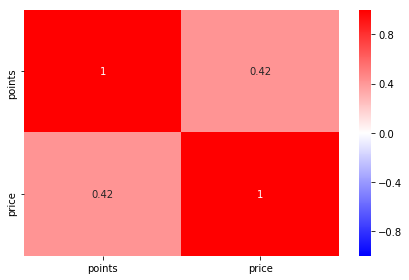

In [5]:
ax = sns.heatmap(wine_clean.corr(), cmap = 'bwr', vmin = -1, annot=True)
plt.tight_layout()

In [6]:
fig = ax.get_figure()

In [7]:
fig.savefig('heatmap.jpeg')

In [8]:
# Categorical correlation Functions
# From: https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
# And: https://github.com/shakedzy/dython/blob/master/dython/nominal.py

import math
import scipy.stats as ss
from collections import Counter

def convert(data, to):
    converted = None
    if to == 'array':
        if isinstance(data, np.ndarray):
            converted = data
        elif isinstance(data, pd.Series):
            converted = data.values
        elif isinstance(data, list):
            converted = np.array(data)
        elif isinstance(data, pd.DataFrame):
            converted = data.as_matrix()
    elif to == 'list':
        if isinstance(data, list):
            converted = data
        elif isinstance(data, pd.Series):
            converted = data.values.tolist()
        elif isinstance(data, np.ndarray):
            converted = data.tolist()
    elif to == 'dataframe':
        if isinstance(data, pd.DataFrame):
            converted = data
        elif isinstance(data, np.ndarray):
            converted = pd.DataFrame(data)
    else:
        raise ValueError("Unknown data conversion: {}".format(to))
    if converted is None:
        raise TypeError('cannot handle data conversion of type: {} to {}'.format(type(data),to))
    else:
        return converted

def conditional_entropy(x, y):
    """
    Calculates the conditional entropy of x given y: S(x|y)
    Wikipedia: https://en.wikipedia.org/wiki/Conditional_entropy
    :param x: list / NumPy ndarray / Pandas DataFrame
        A sequence of measurements
    :param y: list / NumPy ndarray / Pandas DataFrame
        A sequence of measurements
    :return: float
    """
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy


def cramers_v(x, y):
    """
    Calculates Cramer's V statistic for categorical-categorical association.
    Uses correction from Bergsma and Wicher, Journal of the Korean Statistical Society 42 (2013): 323-328.
    This is a symmetric coefficient: V(x,y) = V(y,x)
    Original function taken from: https://stackoverflow.com/a/46498792/5863503
    Wikipedia: https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V
    :param x: list / NumPy ndarray / Pandas DataFrame
        A sequence of categorical measurements
    :param y: list / NumPy ndarray / Pandas DataFrame
        A sequence of categorical measurements
    :return: float
        in the range of [0,1]
    """
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


def theils_u(x, y):
    """
    Calculates Theil's U statistic (Uncertainty coefficient) for categorical-categorical association.
    This is the uncertainty of x given y: value is on the range of [0,1] - where 0 means y provides no information about
    x, and 1 means y provides full information about x.
    This is an asymmetric coefficient: U(x,y) != U(y,x)
    Wikipedia: https://en.wikipedia.org/wiki/Uncertainty_coefficient
    :param x: list / NumPy ndarray / Pandas DataFrame
        A sequence of categorical measurements
    :param y: list / NumPy ndarray / Pandas DataFrame
        A sequence of categorical measurements
    :return: float
        in the range of [0,1]
    """
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x


def correlation_ratio(categories, measurements):
    """
    Calculates the Correlation Ration (sometimes marked by the greek letter Eta) for categorical-continuous association.
    Answers the question - given a continuous value of a measurement, is it possible to know which category is it
    associated with?
    Value is in the range [0,1], where 0 means a category cannot be determined by a continuous measurement, and 1 means
    a category can be determined with absolute certainty.
    Wikipedia: https://en.wikipedia.org/wiki/Correlation_ratio
    :param categories: list / NumPy ndarray / Pandas DataFrame
        A sequence of categorical measurements
    :param measurements: list / NumPy ndarray / Pandas DataFrame
        A sequence of continuous measurements
    :return: float
        in the range of [0,1]
    """
    categories = convert(categories, 'array')
    measurements = convert(measurements, 'array')
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = numerator/denominator
    return eta


In [9]:
def store_correlation_ratio(category):
    correlation_list = [
        correlation_ratio(wine_clean[category], wine_clean['points']),
        correlation_ratio(wine_clean[category], wine_clean['price'])
    ]
    
    print(str(category) + ' association with poiints: ', 
          correlation_list[0])
    print(str(category) + ' association with price: ', 
          correlation_list[1])

    return correlation_list

In [10]:
country_correlations = store_correlation_ratio('country')

country association with poiints:  0.052542967658625685
country association with price:  0.01915324950248344


In [11]:
designation_correlations = store_correlation_ratio('designation')

designation association with poiints:  0.5205972516897167
designation association with price:  0.4447792939327246


In [12]:
province_correlations = store_correlation_ratio('province')

province association with poiints:  0.11749269139253968
province association with price:  0.083881390413612


In [13]:
region_1_correlations = store_correlation_ratio('region_1')

region_1 association with poiints:  0.22548897830854733
region_1 association with price:  0.31028936358589654


In [14]:
region_2_correlations = store_correlation_ratio('region_2')

region_2 association with poiints:  0.042711462310652565
region_2 association with price:  0.032287153430236026


In [15]:
taster_correlations = store_correlation_ratio('taster_name')

taster_name association with poiints:  0.08991694663804563
taster_name association with price:  0.02190771369929919


In [16]:
variety_correlations = store_correlation_ratio('variety')

variety association with poiints:  0.0992906923082972
variety association with price:  0.08251439775538863


In [17]:
winery_correlations = store_correlation_ratio('winery')

winery association with poiints:  0.5232313529086722
winery association with price:  0.5742454629627854


In [18]:
vintage_correlations = store_correlation_ratio('vintage')

vintage association with poiints:  0.02113417381241989
vintage association with price:  0.03432859637521646


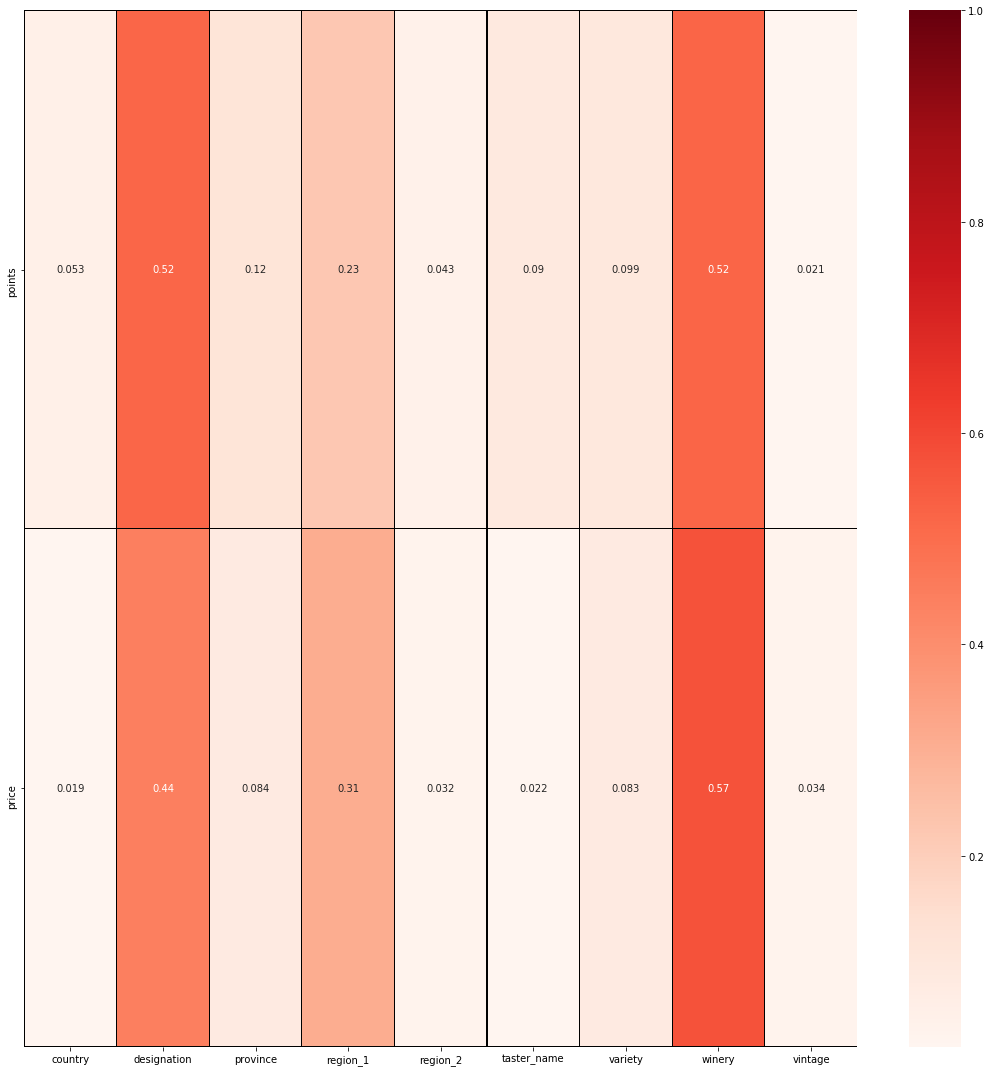

In [19]:
# 'np.column_stack' from:
# https://stackoverflow.com/questions/18730044/converting-two-lists-into-a-matrix
cat_corr_matrix = np.column_stack([country_correlations, 
                                  designation_correlations,
                                  province_correlations,
                                  region_1_correlations,
                                  region_2_correlations,
                                  taster_correlations,
                                  variety_correlations,
                                  winery_correlations,
                                  vintage_correlations])
cat_corr_df = pd.DataFrame(data = cat_corr_matrix, 
                           index=['points', 'price'], 
                           columns=['country', 'designation', 'province',
                                    'region_1', 'region_2', 'taster_name',
                                    'variety', 'winery', 'vintage'])

# figsize for heatmap from:
# https://stackoverflow.com/questions/38913965/make-the-size-of-a-heatmap-bigger-with-seaborn
fig, ax = plt.subplots(figsize=(15,15))
plot = sns.heatmap(cat_corr_df, cmap='Reds', vmax=1.0, annot=True, 
            linewidths=0.1, linecolor='black', ax=ax);
plt.tight_layout()
figure = plot.get_figure()
figure.savefig('theils_u.jpeg')

In [20]:
# Calculate Cramer's V to look at inter-associations
# between the various categories
def store_cramers_v():
    categories = ['country', 'designation', 'province',
                  'region_1', 'region_2', 'taster_name',
                  'variety', 'winery', 'vintage'
                 ]
    cramers_v_list = []
    temp = []
    
    for category_1 in categories:
        for category_2 in categories:
            if category_2 != category_1:
                temp.append(cramers_v(wine_clean[category_1], wine_clean[category_2]))
            else:
                temp.append(1.0)
        cramers_v_list.append(temp)
        temp = []
    
    return cramers_v_list

In [21]:
cramers_v_list = store_cramers_v()

In [22]:
cat_cat_corr_matrix = np.column_stack(cramers_v_list)
cat_cat_corr_df = pd.DataFrame(data = cat_cat_corr_matrix, 
                           index=['country', 'designation', 'province',
                                    'region_1', 'region_2', 'taster_name',
                                    'variety', 'winery', 'vintage'], 
                           columns=['country', 'designation', 'province',
                                    'region_1', 'region_2', 'taster_name',
                                    'variety', 'winery', 'vintage'])

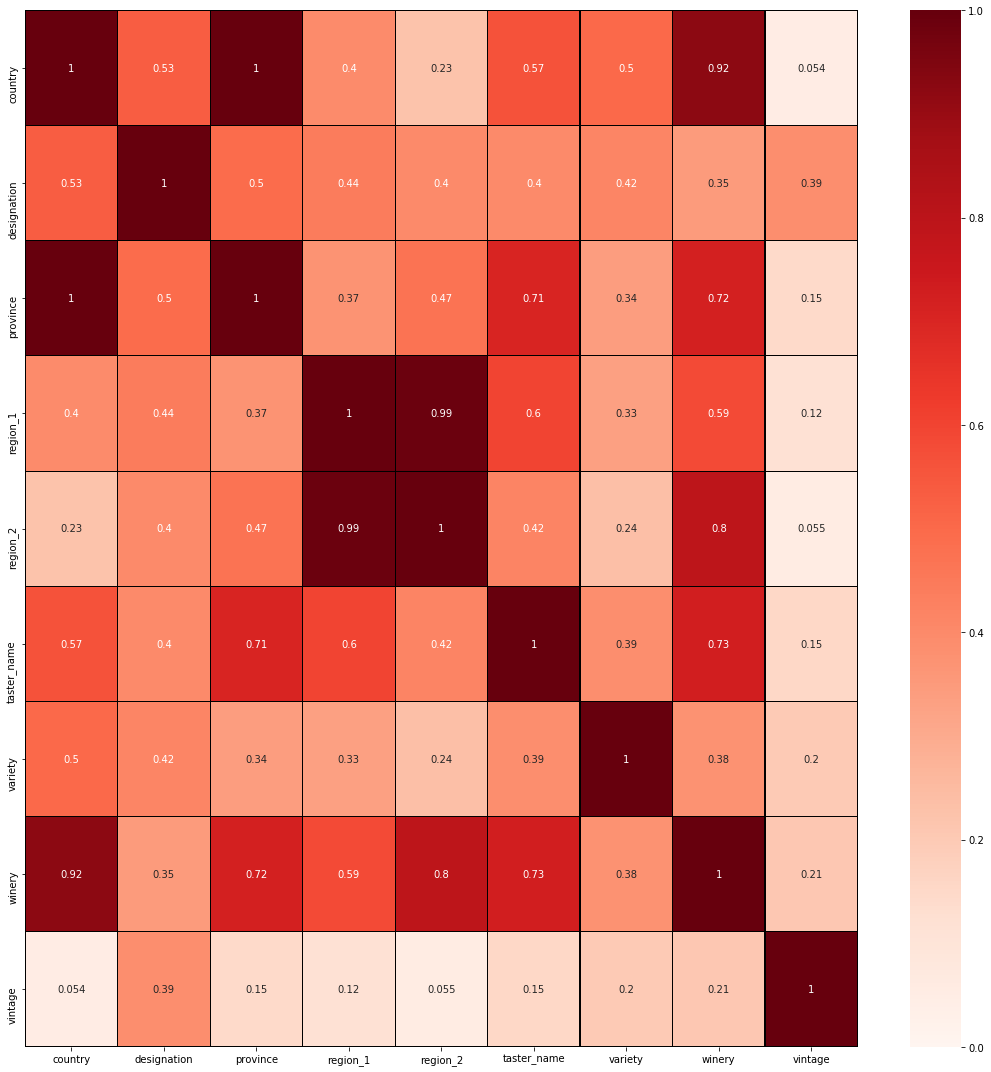

In [23]:
fig, ax = plt.subplots(figsize=(15,15))
plot_2 = sns.heatmap(cat_cat_corr_df, cmap='Reds', vmin=0.0, vmax=1.0, annot=True, 
            linewidths=0.1, linecolor='black', ax=ax);
plt.tight_layout()
figure_2 = plot_2.get_figure()
figure_2.savefig('cramers_v.jpeg')

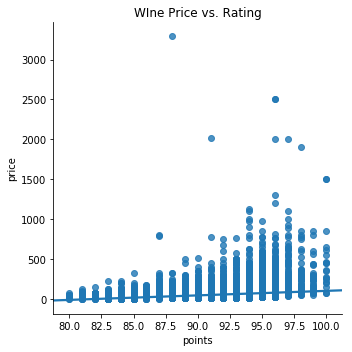

In [24]:
#tight_layout() from:
# https://stackoverflow.com/
# questions/13073045/matplotlib-savefig-size-control
plot_3 = sns.lmplot(x='points', y='price', data=wine_clean);
plt.title('WIne Price vs. Rating')
plt.tight_layout()
figure_3 = plot_3.fig
figure_3.savefig('linear_correlation')

In [25]:
# Decision Tree Graph Image from:
# https://chrisalbon.com/machine_learning/trees_and_forests
# /visualize_a_decision_tree/
from sklearn.tree import DecisionTreeRegressor
from IPython.display import Image  
from sklearn import tree
import pydotplus

In [26]:
wine_x = wine_clean[['designation', 'region_1', 'winery', 'price']]

In [27]:
wine_x = wine_x[wine_x.groupby('designation')['designation'].transform(len) > 20]

In [28]:
wine_x = wine_x[wine_x.groupby('region_1')['region_1'].transform(len) > 20]

In [29]:
wine_x = wine_x[wine_x.groupby('winery')['winery'].transform(len) > 20]

In [30]:
wine_x.shape

(8853, 4)

In [31]:
designation_dummy = pd.get_dummies(wine_x['designation'], 
                                  prefix = 'designation')
region_1_dummy = pd.get_dummies(wine_x['region_1'],
                               prefix = 'region_1')
winery_dummy = pd.get_dummies(wine_x['winery'],
                             prefix = 'winery')

In [32]:
X = pd.concat([designation_dummy, region_1_dummy, winery_dummy], axis=1)
y = wine_x['price']
X.head()

,designation_120,designation_1865 Single Vineyard,designation_Alpha,designation_Anna Maria,designation_Azul Portugal,designation_Bacigalupi Vineyard,designation_Barrel Fermented,designation_Barrel Select,designation_Bien Nacido Vineyard,designation_Black Label,...,winery_Whitehall Lane,winery_Willamette Valley Vineyards,winery_William Hill Estate,winery_Williams Selyem,winery_Willm,winery_Wines & Winemakers,winery_Wolfberger,winery_Woodbridge by Robert Mondavi,winery_Woodward Canyon,winery_Zantho
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
91,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
dtree = DecisionTreeRegressor(max_depth=5, random_state=6292)
model = dtree.fit(X, y)

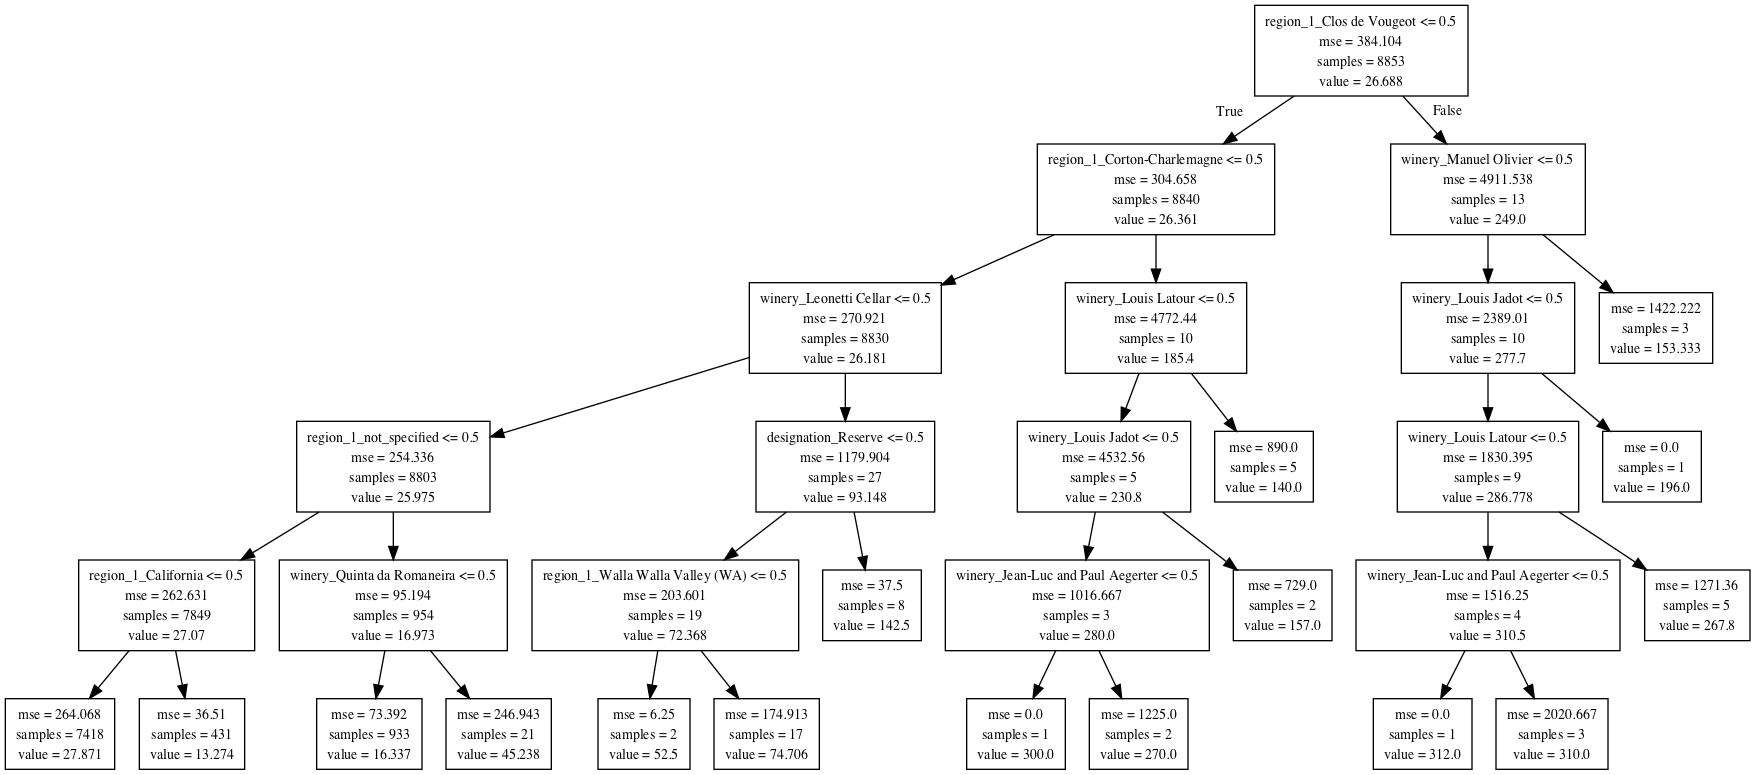

In [34]:
dot_data = tree.export_graphviz(dtree, out_file=None, 
                                feature_names=X.columns, 
                                class_names='price')

graph = pydotplus.graph_from_dot_data(dot_data)

Image(graph.create_png())

In [36]:
graph.write_png('tree.png')

True